In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

cycle_year = '2006'
data = pd.read_csv("../data acquisition/CtC-inkind-transactions/FEC-itoth-" + cycle_year + "cycle-ctc-inkind.txt", sep='|')

In [3]:
data.head()
data.shape

CMTE_ID AMNDT_IND RPT_TP TRANSACTION_PGI    IMAGE_NUM TRANSACTION_TP  \
0  C00406116         N    30G               P  24038651278            24Z   
1  C00385179         A    30G             NaN  27931293992            24Z   
2  C00258277         N    30G               G  24971946905            24Z   
3  C00258277         N    30G               G  24971946904            24Z   
4  C00258277         N    30G               G  24971946905            24Z   

  ENTITY_TP                          NAME        CITY STATE  ...  OCCUPATION  \
0       NaN                           NaN         NaN   NaN  ...         NaN   
1       ORG        FERRARIS ITALIAN VILLA     ADDISON    TX  ...         NaN   
2       ORG                  COPY GENERAL  WASHINGTON    DC  ...         NaN   
3       ORG  TODD ALLAN PRINTING CO. INC.  BELTSVILLE    MD  ...         NaN   
4       ORG                          USPS  WASHINGTON    DC  ...         NaN   

   TRANSACTION_DT  TRANSACTION_AMT   OTHER_ID    TRAN_ID  FILE_NUM MEMO_CD  \
0      2004-11-05           2250.0  C00390401        NaN       NaN     NaN   
1      2004-11-17            931.0  C00388009  SB23.4527  305606.0     NaN   
2      2004-11-19             37.0  C00401737   10379547  152536.0     NaN   
3      2004-11-19            438.0  C00384529   10379551  152536.0     NaN   
4      2004-11-19            265.0  C00384529   10379556  152536.0     NaN   

   MEMO_TEXT               SUB_ID amt_firstdig  
0        NaN  2010420051047675808            2  
1        NaN  4100520071081086697            9  
2   PRINTING  4120520041046204799            3  
3   PRINTING  4120520041046204797            4  
4    POSTAGE  4120520041046204798            2  

[5 rows x 22 columns]

(8048, 22)

In [4]:
data['TRANSACTION_AMT'].describe()
first_digits = data['amt_firstdig']

count      8048.000000
mean        564.861705
std        4312.041260
min           1.000000
25%          56.000000
50%         157.000000
75%         500.000000
max      343913.000000
Name: TRANSACTION_AMT, dtype: float64

<AxesSubplot:>

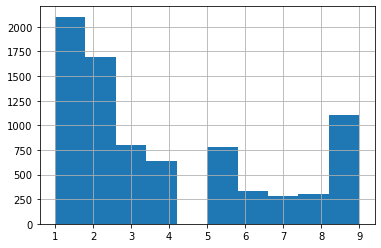

In [5]:
# Now I need to report the frequencies of each of the amt_first digits
# First, get the counts of each digit from 0 through 9
first_digits.hist()
# I wish I could get the histogram for Benford's law data

In [6]:
first_digit_counts = first_digits.value_counts().sort_index()
first_digit_counts
first_digit_counts.keys()

1    2103
2    1698
3     803
4     634
5     777
6     337
7     287
8     305
9    1104
Name: amt_firstdig, dtype: int64

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

In [6]:
# Now get the total number of rows
total_rows = len(data)
first_digit_freq = first_digit_counts/total_rows

In [7]:
# Create Benford's limiting order distribution as a series
benfordd = pd.Series([0.30103,0.17609, 0.12494, 0.09691, 0.07918, 0.06995, 0.05799, 0.05115, 0.04576], index=range(1,10))

# [Goodness of Fit Tests](https://www.statisticshowto.com/goodness-of-fit-test/)
## [Chi-Squared Test](https://www.statisticshowto.com/probability-and-statistics/chi-square/)
First, I need to use the total number of rows to calculate the expected number of counts for each digit from Benford's distribution (expected) and compare it to first_digit_counts (observed).

In [17]:
print('The null hypothesis is that the', cycle_year, 'cycle campaign finance data does follow Benford\'s distribution. \nThe alternative hypothesis is that the', cycle_year, 'cycle campaign finance data does not follow Benford\'s distribution.')

The null hypothesis is that the 2016 cycle campaign finance data does follow Benford's distribution. 
The alternative hypothesis is that the 2016 cycle campaign finance data does not follow Benford's distribution.


In [18]:
import scipy.stats as stats

In [19]:
nrows = data.shape[0]
expected = benfordd*nrows

In [20]:
# source: https://stackoverflow.com/questions/27663924/printing-2-evenly-populated-lists-side-by-side-evenly/27663989
fmt = '{:<8}{:<20}{}'

print(fmt.format('', 'Expected', 'Observed'))
for i, (ben, cyc) in enumerate(zip(expected, first_digit_counts)):
    print(fmt.format(i, ben, cyc))

        Expected            Observed
0       1565.356            1537
1       915.668             1039
2       649.688             839
3       503.93199999999996  339
4       411.736             435
5       363.74              373
6       301.548             250
7       265.98              182
8       237.952             206


In [21]:
stats.chisquare(f_obs=first_digit_counts, f_exp=expected)

Power_divergenceResult(statistic=167.43764411509179, pvalue=4.439652142020408e-32)

The Chi-squared statistic is 167.43 and the corresponding p-value is 4.439652142020408e-32 (basically zero). Since the p-value is less than 0.05, we reject the null hypothesis and claim that the 2016 cycle data do not follow Benford's distribution.
I need to come back and double check this!! It's very odd that the p-value is low when it appears to fit Benford's distribution so well. I should read stats.chisquare documentation more, check that my degrees of freedom are correct, and/or look at [this post](https://stackoverflow.com/questions/42888962/chi-squared-goodness-of-fit-test-in-python-way-too-low-p-values-but-the-fittin) <br>
Ahh, I should come back to it after I have all the proper data. According to Cho & Gaines on p. 220 "$\chi^2$ tests are very sensitive to sample size, having enormous power for large *N*, so that even quite small differences will be statistically significant. This test appears to be too rigid to assess goodness-of-fit well, especially since the Benford proportions do not represent a true distribution that one would expect to occur in the limit (Ley 1996; Giles 2007)."

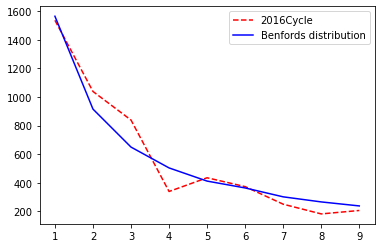

In [22]:
fig, ax = plt.subplots()
ax.plot(first_digit_counts, '--r', label= cycle_year + 'Cycle')
ax.plot(expected, '-b', label='Benford''s distribution')
leg = ax.legend()

Graphically the 2016 election cycle looks somewhat close to Benford's law, but there does seem to be some deviation around 3 being higher, 4 being less frequent, and 8 being less frequent relatively - hard to say if these are actually significant differences though.

In [23]:
first_digit_freq

1    0.295577
2    0.199808
3    0.161346
4    0.065192
5    0.083654
6    0.071731
7    0.048077
8    0.035000
9    0.039615
Name: amt_firstdig, dtype: float64